**Run Expense Categorization Model (SVM, Naive Bayes, Decision Tree, KNN & BERT)**

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

%pip install 'accelerate>=0.26.0'




Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'accelerate": Expected package name at the start of dependency specifier
    'accelerate
    ^


### Expense Categorization: 5-Model Comparison (DT, KNN, SVM, NB, BERT)

In [1]:

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import os

### Disable Weights & Biases logging to prevent login prompt ---

In [2]:
os.environ["WANDB_DISABLED"] = "true"

### 1. DATA PREPARATION

In [3]:
csv_filename = 'C:/Users/User/Downloads/Classification/Classification/expenses.csv'

# try:
    # print(f"Loading {csv_filename}...")
df = pd.read_csv(csv_filename)
    # print("✅ Data Loaded Successfully!")
# except FileNotFoundError:
#     print(f"❌ Error: {csv_filename} not found.")
#     sys.exit(1)

### Split Data
### Vectorization (Needed for all traditional ML models)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")
print("-" * 50)

Training samples: 1600, Testing samples: 400
--------------------------------------------------


### 2. TRADITIONAL ML (4 Models)

In [5]:
print("Running Traditional Machine Learning Models...")
ml_results = {}

Running Traditional Machine Learning Models...


### --- A. Naive Bayes (NB) ---

In [6]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_acc = accuracy_score(y_test, nb_model.predict(X_test_tfidf))
ml_results['Naive Bayes'] = nb_acc
print(f"✅ Naive Bayes Accuracy: {nb_acc:.4f}")

✅ Naive Bayes Accuracy: 1.0000


### --- B. Support Vector Machine (SVM) ---

In [7]:
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_tfidf, y_train)
svm_acc = accuracy_score(y_test, svm_model.predict(X_test_tfidf))
ml_results['SVM'] = svm_acc
print(f"✅ SVM Accuracy: {svm_acc:.4f}")

✅ SVM Accuracy: 1.0000


### --- C. Decision Tree (DT) ---


In [8]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_tfidf, y_train)
dt_acc = accuracy_score(y_test, dt_model.predict(X_test_tfidf))
ml_results['Decision Tree'] = dt_acc
print(f"✅ Decision Tree Accuracy: {dt_acc:.4f}")

✅ Decision Tree Accuracy: 0.9925


### --- D. K-Nearest Neighbors (KNN) ---
### Using n_neighbors=3 for a simple baseline

In [9]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_tfidf, y_train)
knn_acc = accuracy_score(y_test, knn_model.predict(X_test_tfidf))
ml_results['KNN'] = knn_acc
print(f"✅ KNN Accuracy: {knn_acc:.4f}")

print("-" * 50)

✅ KNN Accuracy: 0.9900
--------------------------------------------------


### --- E. Logistic Regression ---

In [13]:
logistic_model = LogisticRegression(max_iter=1000, C=5)

logistic_model.fit(X_train_tfidf, y_train)
logistic_acc = accuracy_score(y_test, logistic_model.predict(X_test_tfidf))
ml_results['Logistic Regression'] = logistic_acc

print(f"✅ Logistic Regression Accuracy: {logistic_acc:.4f}")

print("-" * 50)


✅ Logistic Regression Accuracy: 1.0000
--------------------------------------------------


### 3. DEEP LEARNING (BERT)

In [11]:
print("Initializing Deep Learning (BERT)...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=5)
model.to(device)

class ExpenseDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            padding='max_length', truncation=True, return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = ExpenseDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = ExpenseDataset(X_test.tolist(), y_test.tolist(), tokenizer)

training_args = TrainingArguments(
    output_dir='./results', num_train_epochs=3, per_device_train_batch_size=8,
    logging_dir='./logs', logging_steps=10,
    report_to="none"
)

trainer = Trainer(
    model=model, args=training_args, train_dataset=train_dataset, eval_dataset=test_dataset,
    compute_metrics=lambda p: {"accuracy": accuracy_score(p.label_ids, p.predictions.argmax(-1))}
)

print("Training BERT model (No Login Required)...")
trainer.train()

bert_eval = trainer.evaluate()
bert_acc = bert_eval['eval_accuracy']
ml_results['BERT'] = bert_acc
print(f"✅ BERT Accuracy: {bert_acc:.4f}")
print("-" * 50)


Initializing Deep Learning (BERT)...
Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training BERT model (No Login Required)...


c:\Users\User\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


KeyboardInterrupt: 

# ==========================================
# 4. PLOTTING COMPARISON
# ==========================================

Generating 5-Model Comparison Plot...


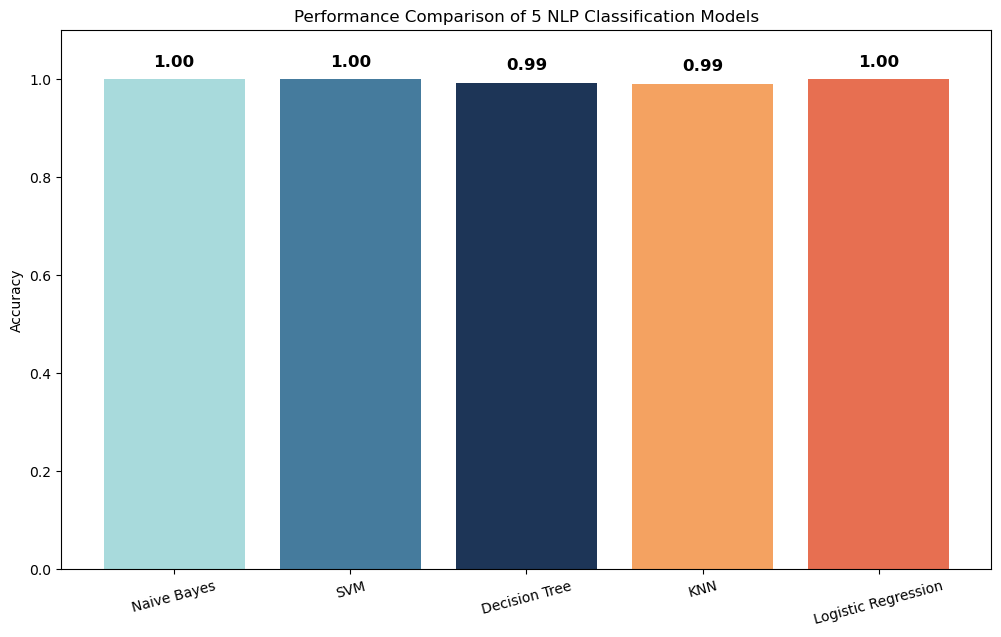

In [14]:
print("Generating 5-Model Comparison Plot...")
models = list(ml_results.keys())
accuracies = list(ml_results.values())

plt.figure(figsize=(12, 7))
# Use a color palette to distinguish ML types
colors = ['#A8DADC', '#457B9D', '#1D3557', '#F4A261', '#E76F51']
bars = plt.bar(models, accuracies, color=colors)
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.title('Performance Comparison of 5 NLP Classification Models')
plt.xticks(rotation=15)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}",
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

# ==========================================
# 5. PREDICTION FUNCTION
# ==========================================

In [12]:

CATEGORY_MAP = {
    0: "Groceries (雜貨/超市購物)", 1: "Transportation (交通)",
    2: "Utilities (公用事業)", 3: "Entertainment (娛樂)",
    4: "Food & Drinks (食物與飲料)"
}

def predict_expense(text_input):
    """Predicts expense category using all five models."""
    global nb_model, svm_model, dt_model, knn_model, model, vectorizer, tokenizer, device, CATEGORY_MAP

    # --- Vectorization ---
    vec = vectorizer.transform([text_input])

    # --- ML Predictions ---
    nb_p = nb_model.predict(vec)[0]
    svm_p = svm_model.predict(vec)[0]
    dt_p = dt_model.predict(vec)[0]
    knn_p = knn_model.predict(vec)[0]

    # --- DL Prediction (BERT) ---
    inputs = tokenizer(text_input, return_tensors="pt", truncation=True, padding=True, max_length=64).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    bert_p = logits.argmax().item()

    print(f"\n--- Prediction for: '{text_input}' ---")
    print(f"**Naive Bayes:** [{nb_p}] {CATEGORY_MAP[nb_p]}")
    print(f"**SVM:** [{svm_p}] {CATEGORY_MAP[svm_p]}")
    print(f"**Decision Tree:** [{dt_p}] {CATEGORY_MAP[dt_p]}")
    print(f"**KNN:** [{knn_p}] {CATEGORY_MAP[knn_p]}")
    print(f"**BERT:** [{bert_p}] {CATEGORY_MAP[bert_p]}")
    print("-" * 40)



In [13]:
# Test with Examples
print("--- Running Predictions on Test Inputs ---")
predict_expense('Sushi and beer with friends HKD120')
predict_expense('Uber $110.50')
predict_expense('Electric bill')
predict_expense('咖哩牛腩飯')
predict_expense('米線')
predict_expense('Concert tickets for VIP seat USD900')
predict_expense('Socks')
predict_expense('恐龍毛公仔')

--- Running Predictions on Test Inputs ---

--- Prediction for: 'Sushi and beer with friends HKD120' ---
**Naive Bayes:** [4] Food & Drinks (食物與飲料)
**SVM:** [4] Food & Drinks (食物與飲料)
**Decision Tree:** [4] Food & Drinks (食物與飲料)
**KNN:** [4] Food & Drinks (食物與飲料)
**BERT:** [4] Food & Drinks (食物與飲料)
----------------------------------------

--- Prediction for: 'Uber $110.50' ---
**Naive Bayes:** [1] Transportation (交通)
**SVM:** [1] Transportation (交通)
**Decision Tree:** [4] Food & Drinks (食物與飲料)
**KNN:** [2] Utilities (公用事業)
**BERT:** [2] Utilities (公用事業)
----------------------------------------

--- Prediction for: 'Electric bill' ---
**Naive Bayes:** [2] Utilities (公用事業)
**SVM:** [2] Utilities (公用事業)
**Decision Tree:** [2] Utilities (公用事業)
**KNN:** [2] Utilities (公用事業)
**BERT:** [2] Utilities (公用事業)
----------------------------------------

--- Prediction for: '咖哩牛腩飯' ---
**Naive Bayes:** [0] Groceries (雜貨/超市購物)
**SVM:** [1] Transportation (交通)
**Decision Tree:** [4] Food & Drinks (食物與